In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import os
from scipy.stats.stats import pearsonr
import itertools
from scipy import stats
import seaborn as sns
matplotlib.rcParams.update({'font.size': 16})

## Notes 44290 (HER2+ Breast Cancer)
The single stains have much worse edge effect.
Define 2 ROIs with similar composition, avoiding edge regions. (x,y,w,h)

44290-112: (cyclic)
- (3200,5500,1500,1500) ROI1 large tumor nest upper left
- (5000,8800,1500,1800) ROI2 large tumor nests lower right
- only two regions in 44290 are suitable, due to autofluorescent regions that are different between single and cyclic stains. 

44290-113 (single PCNA, HER2, ER, CD45)
- (800,3050,1500,1500)
- (2650,6400,1500,1800)

44290-114 (single pHH3, CK14, CD44, CK5)
- (900,2900,1500,1500)
- (2650,6250,1500,1800)

44290-115 (single Vim, CK7, PD1, Lamin A/C)
- (900,2950,1500,1500)
- (2850,6200,1500,1800)

44290-116 (single aSMA, CD68, Ki67, Ecad)
- (850,3000,1500,1500)
- (2650,6250,1500,1800)

## Notes 44294 (Normal Breast)
The single stains on normal tissue don't have such bad edge effect, although they do have to autoflourescence in the DAPI negative areas (i.e. middle of the duct). We can use the whole segmented images, as segmentation based on DAPI will ignore most of the worst autofluorescence areas.

44294-116 was not cropped before segmentation, while the other tissues were.
Therefore, I will use an ROI to make 44294-116 the same size as the other tissues.

44294-116:
- (7200,3580,12725,12365) (scene001)

## Load Data

In [7]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies'

In [20]:
#load threshold, SNR data
df_t = pd.read_csv(f'{codedir}/Metadata/44290/SNR_single_vs_cyclic.csv',index_col=0)

#load metadata from feature extraction
df_m = pd.read_csv(f'{codedir}/Metadata/44290/metadata_single_vs_cyclic.csv',index_col=0)

In [22]:
#import dataframes with mean intensity/centroid from segmentation and feature extraction
df_mi =pd.read_csv(f'{codedir}/Data/features_singlevscyclic.csv',index_col=0)

In [23]:
#add the slide/scene information 
df_mi['scene'] = [item.split('_')[1] for item in df_mi.index]
df_mi['slide'] = [item.split('_')[0] for item in df_mi.index]

df_t['experiment'] = [item.split('_')[0] for item in df_t.condition]
df_t['experimenttype'] = [item.split('_')[2] for item in df_t.condition]
df_t = df_t.sort_values(['color','rounds'])

In [24]:
#cropping used for images (different from the features)
#new 20191209
d_crop_image = {'44290-112':(5000,8800,1300,1800),
 '44290-113':(5886,8111,1300,1800),
 '44290-114':(5010,9242,1300,1800),
 '44290-115':(5975,10490,1300,1800),
 '44290-116':(6336,9174,1300,1800),
 '44294-116':(9547,5459,1300,1800),
 '44294-117':(12180,6092, 1300,1800),
 '44294-118':(10901, 6582, 1300,1800),
 '44294-119':(9853,5557, 1300,1800),
 '44294-120':(10250,5510, 1300,1800),
 }
d_crop_feat = {'44290-112':(5000,8800,1300,1800),
 '44290-113':(2650,6400,1300,1800),
 '44290-114':(2650,6250,1300,1800),
 '44290-115':(2850,6200,1300,1800),
 '44290-116':(2650,6250,1300,1800),
 '44294-116':(7200,3580,12725,12365),
 '44294-117':(0,0,0,0),
 '44294-118':(0,0,0,0),
 '44294-119':(0,0,0,0),
 '44294-120':(0,0,0,0),
 }

In [25]:
#define rois (see notes above about ROIs to exclude autofluorescence)
df_rois = pd.DataFrame()
for s_tissue, t_coord in d_crop_feat.items():
    #print(s_tissue)
    if t_coord == (0,0,0,0):
        df_scene = df_mi[df_mi.slide==s_tissue]
    else:
        x_min = t_coord[0]
        x_max = t_coord[0] + t_coord[2]
        y_min = t_coord[1]
        y_max = t_coord[1] + t_coord[3]
        df_scene = df_mi[df_mi.slide==s_tissue]
        df_scene = df_scene.loc[(x_max > df_scene.DAPI_X) & (df_scene.DAPI_X > x_min)]
        df_scene = df_scene.loc[(y_max > df_scene.DAPI_Y) & (df_scene.DAPI_Y > y_min)]
    df_rois = df_rois.append(df_scene)

In [26]:
# which markers had exposure normalization?
# in our earliest versions of feature extraction, we scalse the mean intensity to a reference exposure time (refexp).
#For accurate reflection of the images, we nedd to "unscale" by this factor
df_m[(df_m.exposure/df_m.refexp != 1.0)]

,marker,rounds,color,minimum,max,exposure,refexp,location,slide,condition
44290-112_0,CD20,R1,c2,2500,5000,100,80,Ring,44290-112,cyclic_R1-5_tumor
44290-112_3,CK19,R1,c5,4000,65535,750,300,Ring,44290-112,cyclic_R1-5_tumor
44290-112_9,CK14,R3,c3,5002,65535,10,3,Ring,44290-112,cyclic_R1-5_tumor
44290-112_11,CK5,R3,c5,2202,65535,500,100,Ring,44290-112,cyclic_R1-5_tumor
44290-112_16,aSMA,R5,c2,1202,65535,30,10,Ring,44290-112,cyclic_R1-5_tumor
44290-112_21,Ecadb,R6,c3,2002,65535,30,50,Ring,44290-112,cyclic_R1-5_tumor
44290-112_22,CD44b,R6,c4,2002,65535,60,100,Ring,44290-112,cyclic_R1-5_tumor


# Percent Positive

Thresholds were set on the images, using the pattern of staining to set an intensity value above which pixels were considered positive for a stain.

Here, the same theresholds are applied to the single cell mean intensity values. If a cell has a mean intensity above the pixel threshold, it is considered positive. Percent of positive cells over all segmented cells is calculated for each marker.

In [27]:
#calculate positive cells based on thresholding the mean intensity dataframe

#empty dataframe
df_pos = pd.DataFrame()

#for each sample
for s_index in df_t.index:
    s_exp = df_t.loc[s_index,'experiment']
    s_tissue = df_t.loc[s_index,'scene']
    s_marker = df_t.loc[s_index,'marker']
    s_type = df_t.loc[s_index,'experimenttype']
    df_m_slide = df_m[(df_m.slide==s_tissue) & (df_m.marker == s_marker)]
    if len(df_m_slide) !=1:
        print(df_m_slide)
    #when the features were extracted we had some exposure normalization ... need to undo
    i_thresh = df_t.loc[s_index,'minimum']/(df_m_slide.loc[:,'refexp']/df_m_slide.loc[:,'exposure'])
    s_marker_loc = df_rois.columns[pd.Series([item.split('_')[0]==s_marker for item in df_rois.columns])][0]
    df_pos.loc[s_marker,f'{s_exp}_{s_type}'] = (df_rois[df_rois.slide==s_tissue].loc[:,s_marker_loc] > i_thresh[0]).sum()
   

In [28]:
#generate dataframe for plotting
#tumor
df_percent = pd.DataFrame()
df_percent['tumor'] = (df_pos.dropna(axis=0).single_tumor/df_pos.dropna(axis=0).cyclic_tumor).fillna(1)
#normal
df_percent['normal'] = (df_pos.dropna(axis=0).single_normal/df_pos.dropna(axis=0).cyclic_normal).fillna(1)



df_tum = pd.DataFrame(df_percent.unstack().tumor, columns=['value'])
df_norm = pd.DataFrame(df_percent.unstack().normal, columns=['value'])
df_tum['type'] = 'tumor'
df_norm['type'] = 'normal'
df_tum['marker'] = df_tum.index.tolist()
df_norm['marker'] = df_norm.index.tolist()
df_longer = df_tum.append(df_norm)
df_longer = df_longer.drop('pH3')

ls_order = df_tum.index

#stats
print(df_longer.groupby('marker').mean().mean())
print(df_longer.groupby('marker').mean().std())


value    0.963781
dtype: float64
value    0.188409
dtype: float64


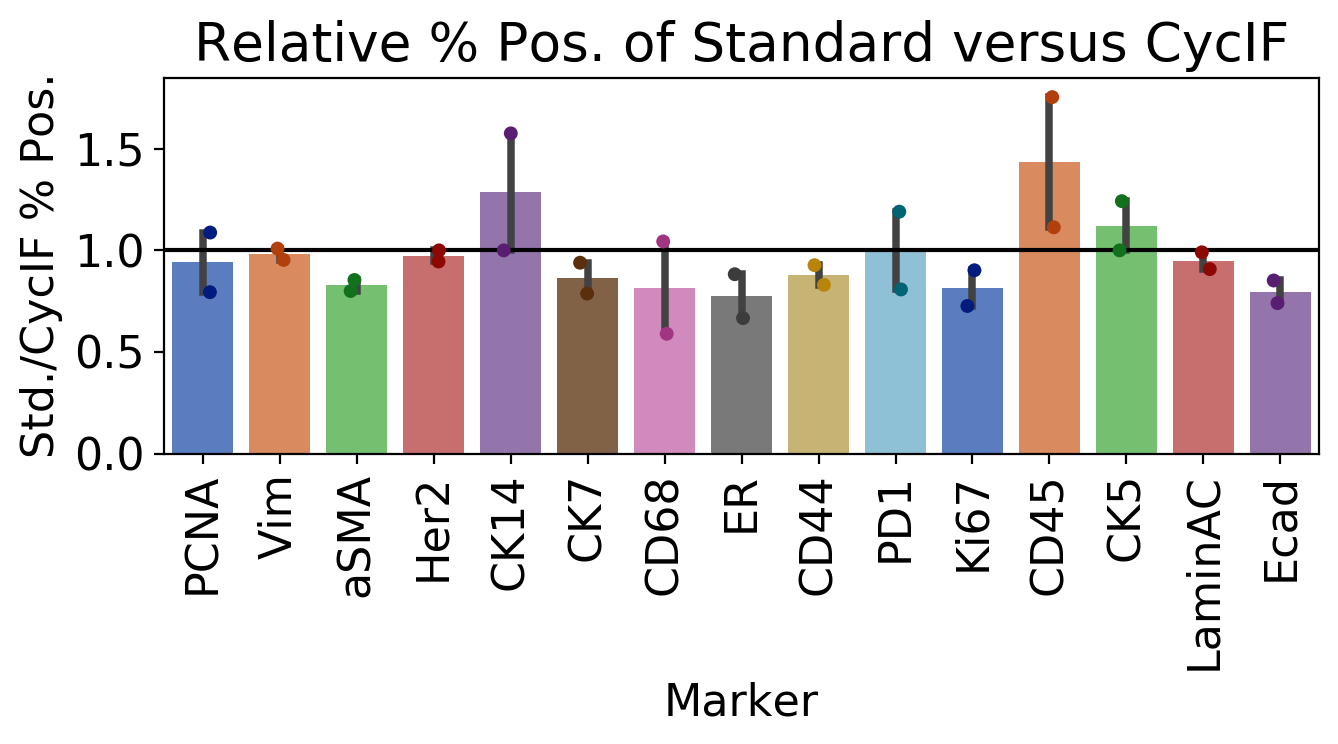

In [29]:
#barplot

s_title = 'Relative % Pos. of Standard versus CycIF'
s_ylabel = "Std./CycIF % Pos."
s_figname =f'{codedir}/Figures/44290/Percent_Positive_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted',ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)

ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)


# mean intensity

The mean intensity of pixels above the threshold

In [30]:
#generate dataframe for plotting
df_percent = pd.DataFrame()
se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='tumor')]).groupby('marker').meanpos.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='tumor')]).groupby('marker').meanpos.mean()
df_percent['tumor'] = (se_single/se_tumor).fillna(1)

se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='normal')]).groupby('marker').meanpos.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='normal')]).groupby('marker').meanpos.mean()
df_percent['normal'] = (se_single/se_tumor).fillna(1)

df_tum = pd.DataFrame(df_percent.unstack().tumor, columns=['value'])
df_norm = pd.DataFrame(df_percent.unstack().normal, columns=['value'])
df_tum['type'] = 'tumor'
df_norm['type'] = 'normal'
df_tum['marker'] = df_tum.index.tolist()
df_norm['marker'] = df_norm.index.tolist()
df_tum = df_tum.reindex(ls_order)
df_norm = df_norm.reindex(ls_order)
df_longer = df_tum.append(df_norm)
df_longer = df_longer.drop('pH3')

#stats
print(df_longer.groupby('marker').mean().mean())
print(df_longer.groupby('marker').mean().std())


value    1.215738
dtype: float64
value    0.388301
dtype: float64


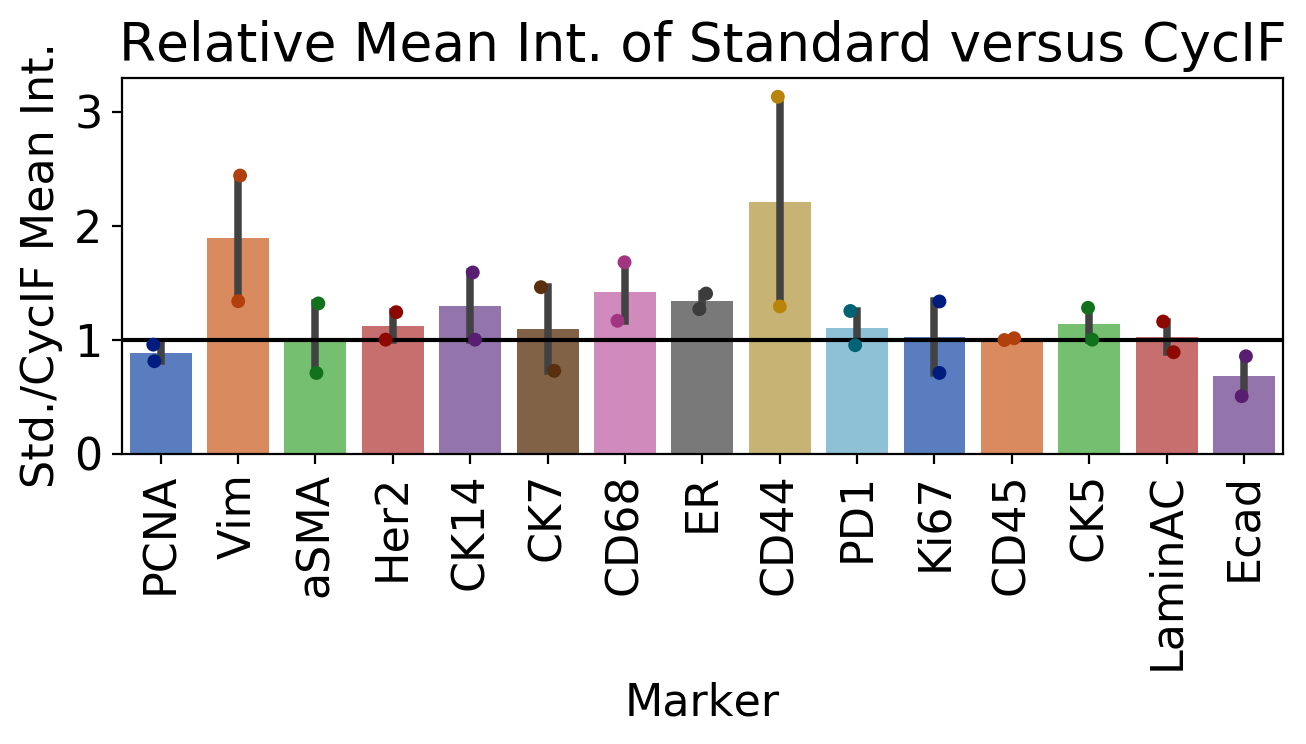

In [31]:
#barplot

s_title = 'Relative Mean Int. of Standard versus CycIF'
s_ylabel = "Std./CycIF Mean Int."
s_figname =f'{codedir}/Figures/44290/Mean_Int_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted', ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,3.3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)


# background

the mean intensity of pixels below the threshold

In [32]:
#generate dataframe for plotting
df_percent = pd.DataFrame()
se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='tumor')]).groupby('marker').meanneg.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='tumor')]).groupby('marker').meanneg.mean()
df_percent['tumor'] = (se_single/se_tumor).fillna(1)

se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='normal')]).groupby('marker').meanneg.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='normal')]).groupby('marker').meanneg.mean()
df_percent['normal'] = (se_single/se_tumor).fillna(1)


df_tum = pd.DataFrame(df_percent.unstack().tumor, columns=['value'])
df_norm = pd.DataFrame(df_percent.unstack().normal, columns=['value'])
df_tum['type'] = 'tumor'
df_norm['type'] = 'normal'
df_tum['marker'] = df_tum.index.tolist()
df_norm['marker'] = df_norm.index.tolist()
df_tum = df_tum.reindex(ls_order)
df_norm = df_norm.reindex(ls_order)
df_longer = df_tum.append(df_norm)
df_longer = df_longer.drop('pH3')

#stats
print(df_longer.groupby('marker').mean().mean())
print(df_longer.groupby('marker').mean().std())


value    1.336011
dtype: float64
value    0.505594
dtype: float64


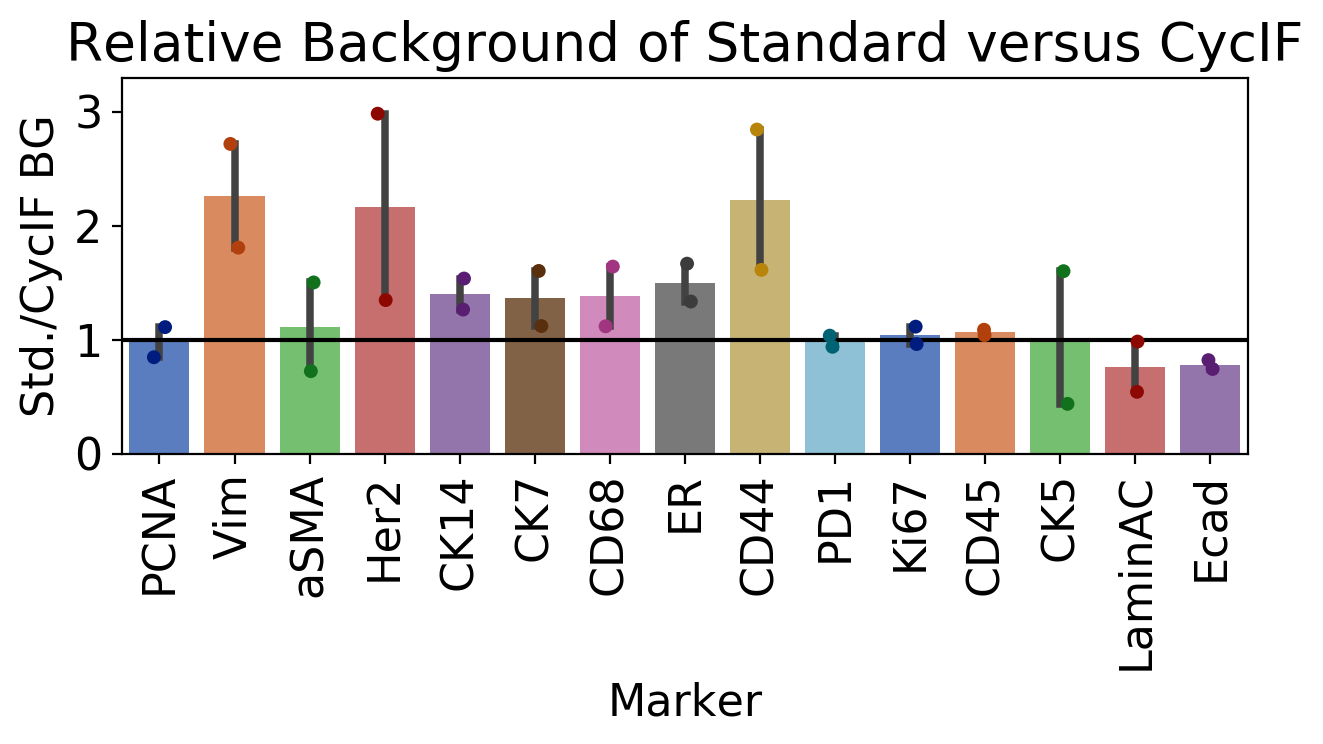

In [33]:
#barplot

s_title = 'Relative Background of Standard versus CycIF'
s_ylabel = "Std./CycIF BG"
s_figname =f'{codedir}/Figures/44290/BG_Int_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted', ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,3.3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)



# SNR

mean intensity above threshold/mean intensity below threshold

In [34]:
df_t['SNR'] = df_t.meanpos/df_t.meanneg

In [35]:
#generate dataframe for plotting
df_percent = pd.DataFrame()
se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='tumor')]).groupby('marker').SNR.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='tumor')]).groupby('marker').SNR.mean()
df_percent['tumor'] = (se_single/se_tumor).fillna(1)

se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='normal')]).groupby('marker').SNR.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='normal')]).groupby('marker').SNR.mean()
df_percent['normal'] = (se_single/se_tumor).fillna(1)

df_tum = pd.DataFrame(df_percent.unstack().tumor, columns=['value'])
df_norm = pd.DataFrame(df_percent.unstack().normal, columns=['value'])
df_tum['type'] = 'tumor'
df_norm['type'] = 'normal'
df_tum['marker'] = df_tum.index.tolist()
df_norm['marker'] = df_norm.index.tolist()
df_tum = df_tum.reindex(ls_order)
df_norm = df_norm.reindex(ls_order)
df_longer = df_tum.append(df_norm)
df_longer = df_longer.drop('pH3')

#stats
print(df_longer.groupby('marker').mean().mean())
print(df_longer.groupby('marker').mean().std())


value    0.966615
dtype: float64
value    0.147947
dtype: float64


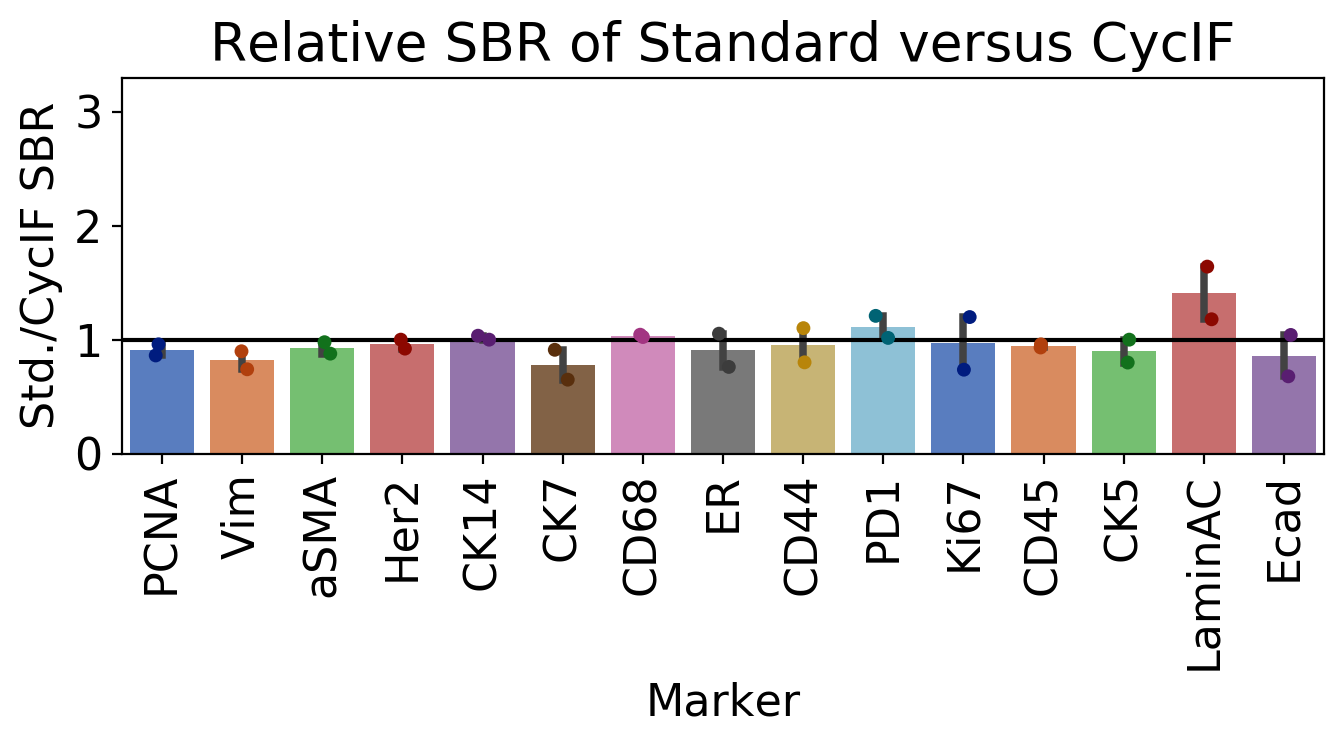

In [36]:
#barplot
s_title = 'Relative SBR of Standard versus CycIF'
s_ylabel = "Std./CycIF SBR"
s_figname =f'{codedir}/Figures/44290/SBR_Ratio_Single-Cyclic_0-3.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted',ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,3.3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)


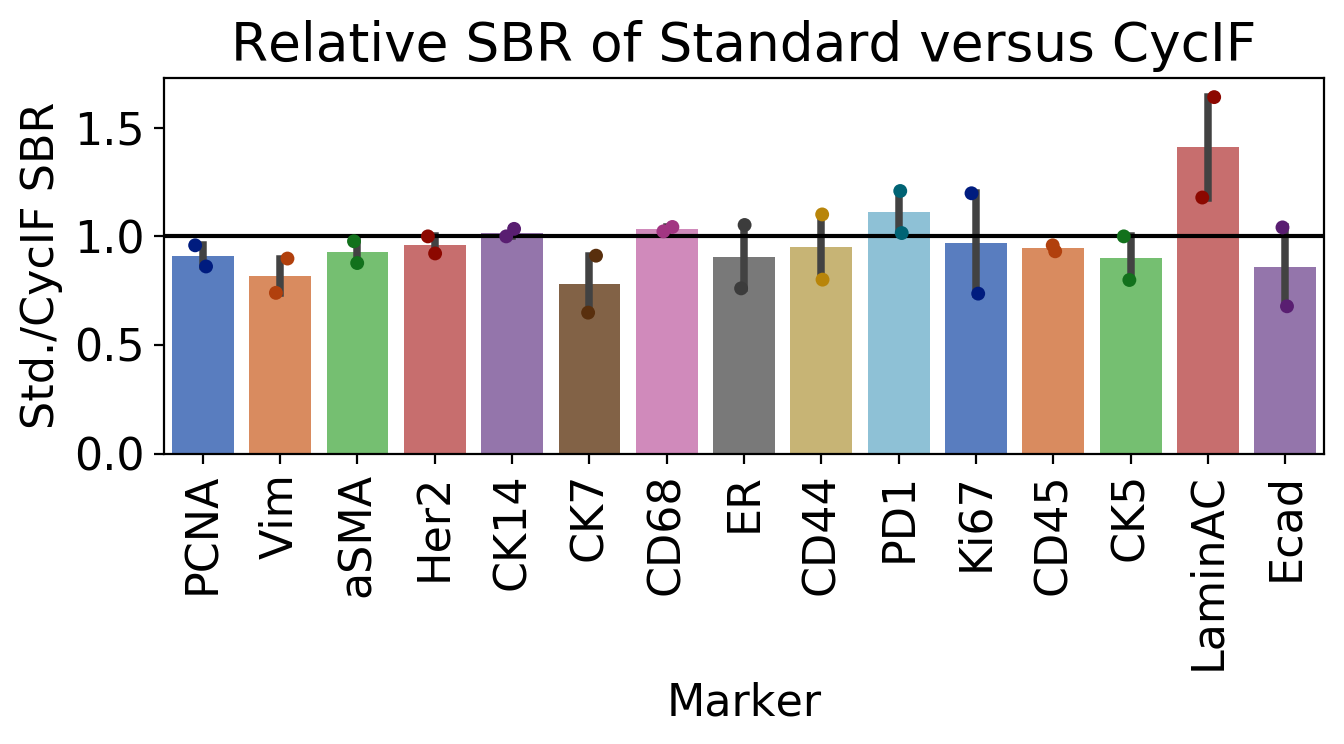

In [37]:
#barplot zoomed in
s_title = 'Relative SBR of Standard versus CycIF'
s_ylabel = "Std./CycIF SBR"
s_figname =f'{codedir}/Figures/44290/SBR_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted', ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
#ax.set_ylim(0,3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)
